In [25]:
import torch # version 2.1.2
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
import cv2
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import YoloV1
from dataset import VOCDataset
from loss import YoloLoss
from utils import *

seed = 3301 #pseudorandom seed, gets the same dataset loading
torch.manual_seed(seed)

torch.autograd.set_detect_anomaly(True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", DEVICE)

Using device cuda


In [16]:
# Hyperparameters for our model
LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8
WEIGHT_DECAY = 0    # no regularization in order for fast training
EPOCHS = 100

# Other variables for training
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"

In [17]:
# trains through the entire dataset once
def train_fn(train_loader, model, optimizer, loss_fn, epoch_iter=None):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE) 
        # x has shape torch.Size([batchSize, 3, 448, 448])
        # y has shape torch.Size([batchSize, 7, 7, 30])
        
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        
        # backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())
    if epoch_iter != None:
        print(f"Average loss per image for epoch {epoch_iter} was: {sum(mean_loss)/len(mean_loss)}")
    else:
        print(f"Average loss per image for this epoch was: {sum(mean_loss)/len(mean_loss)}")

In [18]:
model = YoloV1(split_size = 7, num_boxes = 2, num_classes = 20).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
loss_fn = YoloLoss()

if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

transform = transforms.Compose([
    transforms.Resize((448, 448)), 
    transforms.ToTensor()
    ])

train_dataset = VOCDataset(
    "data/100examples.csv", 
    transform = transform, 
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR
)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
    shuffle = False,
    drop_last = False       #We have 8 examples, so false, but true if more than BATCH_SIZE
)

# train_dataset = VOCDataset(
#     "data/8examples.csv", 
#     transform = transform, 
#     img_dir = IMG_DIR,
#     label_dir = LABEL_DIR
# )

# train_loader = DataLoader(
#     dataset = train_dataset,
#     batch_size = BATCH_SIZE,
#     num_workers= NUM_WORKERS,
#     pin_memory= PIN_MEMORY,
#     shuffle = False,
#     drop_last = False       #We have 8 examples, so false, but true if more than BATCH_SIZE
# )

model.train()
for epoch in range(EPOCHS):
    pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold = 0.5, prob_threshold = 0.4)
    # pred_boxes (list of lists) = [[train_idx, class_prediction, prob_score, x1, y1, x2, y2],...], each list within the big list represents a bbox
    # target_boxes = ^
    # note: the length of these lists >= numDatapoints

    mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
    print(f"Train mAP: {mean_avg_prec}")
    # if mean_avg_prec > 0.9:
    #     checkpoint = {
    #     "state_dict": model.state_dict(),
    #     "optimizer": optimizer.state_dict(),
    #     }
    #     save_checkpoint(checkpoint, filename= LOAD_MODEL_FILE)
    #     import time
    #     time.sleep(10)
    train_fn(train_loader, model, optimizer, loss_fn, epoch_iter=epoch+1)

Train mAP: 0.0


100%|██████████| 13/13 [00:03<00:00,  3.77it/s, loss=537]

Average loss per image for epoch 1 was: 433.84278165377106


Train mAP: 0.0


100%|██████████| 13/13 [00:03<00:00,  3.76it/s, loss=255]

Average loss per image for epoch 2 was: 231.1902841421274


Train mAP: 0.0


100%|██████████| 13/13 [00:03<00:00,  3.73it/s, loss=216]

Average loss per image for epoch 3 was: 157.1743615957407


Train mAP: 0.0


100%|██████████| 13/13 [00:03<00:00,  3.73it/s, loss=162]

Average loss per image for epoch 4 was: 119.13903515155499


Train mAP: 0.0003205127432011068


100%|██████████| 13/13 [00:03<00:00,  3.70it/s, loss=150]

Average loss per image for epoch 5 was: 110.70269540640024


Train mAP: 0.000909204303752631


100%|██████████| 13/13 [00:03<00:00,  3.70it/s, loss=147]

Average loss per image for epoch 6 was: 121.4061772273137


Train mAP: 0.016793761402368546


100%|██████████| 13/13 [00:03<00:00,  3.68it/s, loss=156]

Average loss per image for epoch 7 was: 123.50827026367188


Train mAP: 0.002636498771607876


100%|██████████| 13/13 [00:03<00:00,  3.66it/s, loss=160]

Average loss per image for epoch 8 was: 123.53748262845554


Train mAP: 0.006268764846026897


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=154]

Average loss per image for epoch 9 was: 122.35419581486629


Train mAP: 0.00419253297150135


100%|██████████| 13/13 [00:03<00:00,  3.62it/s, loss=127]

Average loss per image for epoch 10 was: 111.56683349609375


Train mAP: 0.02267254889011383


100%|██████████| 13/13 [00:03<00:00,  3.61it/s, loss=113]

Average loss per image for epoch 11 was: 109.19583951509915


Train mAP: 0.030815809965133667


100%|██████████| 13/13 [00:03<00:00,  3.61it/s, loss=104] 

Average loss per image for epoch 12 was: 93.17223358154297


Train mAP: 0.04779110103845596


100%|██████████| 13/13 [00:03<00:00,  3.59it/s, loss=119] 

Average loss per image for epoch 13 was: 85.63645436213567


Train mAP: 0.11080531775951385


100%|██████████| 13/13 [00:03<00:00,  3.60it/s, loss=115] 

Average loss per image for epoch 14 was: 83.8591663654034


Train mAP: 0.14392797648906708


100%|██████████| 13/13 [00:03<00:00,  3.63it/s, loss=91.5]

Average loss per image for epoch 15 was: 78.5560434781588


Train mAP: 0.14097000658512115


100%|██████████| 13/13 [00:03<00:00,  3.63it/s, loss=106] 

Average loss per image for epoch 16 was: 78.85314061091496


Train mAP: 0.13837039470672607


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=111] 

Average loss per image for epoch 17 was: 81.60562251164363


Train mAP: 0.14398370683193207


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=102] 

Average loss per image for epoch 18 was: 72.4831187908466


Train mAP: 0.18484386801719666


100%|██████████| 13/13 [00:03<00:00,  3.66it/s, loss=90.4]

Average loss per image for epoch 19 was: 66.21265059251051


Train mAP: 0.23130881786346436


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=87]  

Average loss per image for epoch 20 was: 67.87063716008113


Train mAP: 0.2125755250453949


100%|██████████| 13/13 [00:03<00:00,  3.67it/s, loss=76.4]

Average loss per image for epoch 21 was: 66.8909316429725


Train mAP: 0.20323853194713593


100%|██████████| 13/13 [00:03<00:00,  3.66it/s, loss=63.8]

Average loss per image for epoch 22 was: 55.80765240009014


Train mAP: 0.24598972499370575


100%|██████████| 13/13 [00:03<00:00,  3.66it/s, loss=61.1]

Average loss per image for epoch 23 was: 49.817681532639725


Train mAP: 0.26342445611953735


100%|██████████| 13/13 [00:03<00:00,  3.68it/s, loss=59.7]

Average loss per image for epoch 24 was: 45.65479953472431


Train mAP: 0.31875476241111755


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=63.6]

Average loss per image for epoch 25 was: 47.4021494938777


Train mAP: 0.2763808071613312


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=68.2]

Average loss per image for epoch 26 was: 47.381836084219124


Train mAP: 0.32294636964797974


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=58.1]

Average loss per image for epoch 27 was: 48.12762099045973


Train mAP: 0.37954583764076233


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=56.8]

Average loss per image for epoch 28 was: 47.012250019953804


Train mAP: 0.3444470763206482


100%|██████████| 13/13 [00:03<00:00,  3.63it/s, loss=63.7]

Average loss per image for epoch 29 was: 48.090020399827225


Train mAP: 0.3492947518825531


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=51.2]

Average loss per image for epoch 30 was: 45.995865895197944


Train mAP: 0.46337899565696716


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=44.3]

Average loss per image for epoch 31 was: 41.365824919480545


Train mAP: 0.3570276200771332


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=49.7]

Average loss per image for epoch 32 was: 40.69439169076773


Train mAP: 0.4295525550842285


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=50.7]

Average loss per image for epoch 33 was: 41.61864823561449


Train mAP: 0.40953224897384644


100%|██████████| 13/13 [00:03<00:00,  3.63it/s, loss=44.7]

Average loss per image for epoch 34 was: 39.404206202580376


Train mAP: 0.4705614447593689


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=50.4]

Average loss per image for epoch 35 was: 38.27416126544659


Train mAP: 0.39692458510398865


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=42.3]

Average loss per image for epoch 36 was: 40.401609860933746


Train mAP: 0.43953266739845276


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=38.2]

Average loss per image for epoch 37 was: 37.57160700284518


Train mAP: 0.48154371976852417


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=36.1]

Average loss per image for epoch 38 was: 32.38017375652607


Train mAP: 0.540004312992096


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=34.9]

Average loss per image for epoch 39 was: 27.118429477398212


Train mAP: 0.5313354730606079


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=31.5]

Average loss per image for epoch 40 was: 24.209510509784405


Train mAP: 0.5808647871017456


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=31.8]

Average loss per image for epoch 41 was: 23.21220882122333


Train mAP: 0.5721831321716309


100%|██████████| 13/13 [00:03<00:00,  3.66it/s, loss=31.7]

Average loss per image for epoch 42 was: 23.22725141965426


Train mAP: 0.5687459707260132


100%|██████████| 13/13 [00:03<00:00,  3.63it/s, loss=30.1]

Average loss per image for epoch 43 was: 22.642095272357647


Train mAP: 0.5951653718948364


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=27.1]

Average loss per image for epoch 44 was: 20.866001202509953


Train mAP: 0.6032537221908569


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=30.5]

Average loss per image for epoch 45 was: 21.968388117276707


Train mAP: 0.6223767995834351


100%|██████████| 13/13 [00:03<00:00,  3.61it/s, loss=26.7]

Average loss per image for epoch 46 was: 20.715089871333195


Train mAP: 0.5987211465835571


100%|██████████| 13/13 [00:03<00:00,  3.62it/s, loss=26.1]

Average loss per image for epoch 47 was: 20.745097453777607


Train mAP: 0.5752199292182922


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=24.1]

Average loss per image for epoch 48 was: 19.484268628633938


Train mAP: 0.6080223917961121


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=24.1]

Average loss per image for epoch 49 was: 17.54641026716966


Train mAP: 0.6008730530738831


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=21.9]

Average loss per image for epoch 50 was: 16.237579565781814


Train mAP: 0.6457539796829224


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=22.8]

Average loss per image for epoch 51 was: 17.325724088228664


Train mAP: 0.567041277885437


100%|██████████| 13/13 [00:03<00:00,  3.62it/s, loss=21.4]

Average loss per image for epoch 52 was: 19.090750767634464


Train mAP: 0.6448007822036743


100%|██████████| 13/13 [00:03<00:00,  3.63it/s, loss=22.5]

Average loss per image for epoch 53 was: 18.231762372530422


Train mAP: 0.6295568943023682


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=21.9]

Average loss per image for epoch 54 was: 16.214368526752178


Train mAP: 0.6285690665245056


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=24.1]

Average loss per image for epoch 55 was: 14.639336585998535


Train mAP: 0.6208123564720154


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=24.9]

Average loss per image for epoch 56 was: 14.325248534862812


Train mAP: 0.6413506269454956


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=25.8]

Average loss per image for epoch 57 was: 14.76558567927434


Train mAP: 0.6203777194023132


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=19.2]

Average loss per image for epoch 58 was: 13.638525816110464


Train mAP: 0.677915632724762


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=19.3]

Average loss per image for epoch 59 was: 13.163438283480131


Train mAP: 0.6472225785255432


100%|██████████| 13/13 [00:03<00:00,  3.66it/s, loss=16.7]

Average loss per image for epoch 60 was: 13.552810302147499


Train mAP: 0.6747385859489441


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=16.7]

Average loss per image for epoch 61 was: 12.41755038041335


Train mAP: 0.6315339207649231


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=17]  

Average loss per image for epoch 62 was: 12.806150142963116


Train mAP: 0.6411945223808289


100%|██████████| 13/13 [00:03<00:00,  3.63it/s, loss=15.2]

Average loss per image for epoch 63 was: 13.15566506752601


Train mAP: 0.6876929998397827


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=15.7]

Average loss per image for epoch 64 was: 13.563870319953331


Train mAP: 0.6369488835334778


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=14.9]

Average loss per image for epoch 65 was: 13.735305529374342


Train mAP: 0.6608914136886597


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=14.1]

Average loss per image for epoch 66 was: 15.048644065856934


Train mAP: 0.6949096918106079


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=17.4]

Average loss per image for epoch 67 was: 15.417567106393667


Train mAP: 0.6229425668716431


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=16.6]

Average loss per image for epoch 68 was: 15.8640775680542


Train mAP: 0.642224907875061


100%|██████████| 13/13 [00:03<00:00,  3.63it/s, loss=19.2]

Average loss per image for epoch 69 was: 16.009452673105095


Train mAP: 0.6257429122924805


100%|██████████| 13/13 [00:03<00:00,  3.62it/s, loss=17.8]

Average loss per image for epoch 70 was: 16.337870671198917


Train mAP: 0.6298733353614807


100%|██████████| 13/13 [00:03<00:00,  3.63it/s, loss=14.6]

Average loss per image for epoch 71 was: 15.681508504427397


Train mAP: 0.619074821472168


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=15.6]

Average loss per image for epoch 72 was: 14.734319320091835


Train mAP: 0.6439854502677917


100%|██████████| 13/13 [00:03<00:00,  3.63it/s, loss=15.3]

Average loss per image for epoch 73 was: 14.557732948890099


Train mAP: 0.6365441083908081


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=11.3]

Average loss per image for epoch 74 was: 13.626438544346737


Train mAP: 0.6721600294113159


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=11.2]

Average loss per image for epoch 75 was: 12.73390084046584


Train mAP: 0.6563535928726196


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=11]  

Average loss per image for epoch 76 was: 12.331165460439829


Train mAP: 0.6860573887825012


100%|██████████| 13/13 [00:03<00:00,  3.62it/s, loss=10.2]

Average loss per image for epoch 77 was: 10.44184765448937


Train mAP: 0.6774271726608276


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=10.2]

Average loss per image for epoch 78 was: 10.102623095879188


Train mAP: 0.7073681354522705


100%|██████████| 13/13 [00:03<00:00,  3.63it/s, loss=9.62]

Average loss per image for epoch 79 was: 10.12434933735774


Train mAP: 0.6567429900169373


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=9.81]

Average loss per image for epoch 80 was: 10.092468481797438


Train mAP: 0.674144446849823


100%|██████████| 13/13 [00:03<00:00,  3.41it/s, loss=9.47]

Average loss per image for epoch 81 was: 9.175650669978214


Train mAP: 0.692982017993927


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=8.75]

Average loss per image for epoch 82 was: 8.42211099771353


Train mAP: 0.7034403681755066


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=9.9] 

Average loss per image for epoch 83 was: 8.422429451575645


Train mAP: 0.7093321084976196


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=11.5]

Average loss per image for epoch 84 was: 8.998526866619404


Train mAP: 0.7060362100601196


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=11.8]

Average loss per image for epoch 85 was: 8.827002305250902


Train mAP: 0.679742693901062


100%|██████████| 13/13 [00:03<00:00,  3.66it/s, loss=10.9]

Average loss per image for epoch 86 was: 7.801001842205341


Train mAP: 0.6837072372436523


100%|██████████| 13/13 [00:03<00:00,  3.67it/s, loss=11.9]

Average loss per image for epoch 87 was: 7.584697778408344


Train mAP: 0.6884225010871887


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=15]  

Average loss per image for epoch 88 was: 8.423931818742018


Train mAP: 0.6974114775657654


100%|██████████| 13/13 [00:03<00:00,  3.66it/s, loss=17.4]

Average loss per image for epoch 89 was: 9.073730505429781


Train mAP: 0.6861847639083862


100%|██████████| 13/13 [00:03<00:00,  3.66it/s, loss=17.3]

Average loss per image for epoch 90 was: 8.958399369166447


Train mAP: 0.6742856502532959


100%|██████████| 13/13 [00:03<00:00,  3.61it/s, loss=16.9]

Average loss per image for epoch 91 was: 8.64947880231417


Train mAP: 0.6751487255096436


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=17.9]

Average loss per image for epoch 92 was: 8.985864675962008


Train mAP: 0.6918197870254517


100%|██████████| 13/13 [00:03<00:00,  3.63it/s, loss=17.3]

Average loss per image for epoch 93 was: 9.76771431702834


Train mAP: 0.6749619245529175


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=12.4]

Average loss per image for epoch 94 was: 8.660189958719107


Train mAP: 0.6638399362564087


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=12.8]

Average loss per image for epoch 95 was: 8.797877238346981


Train mAP: 0.674138069152832


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=9.25]

Average loss per image for epoch 96 was: 8.360470404991737


Train mAP: 0.6414830088615417


100%|██████████| 13/13 [00:03<00:00,  3.62it/s, loss=11.3]

Average loss per image for epoch 97 was: 9.522859793442946


Train mAP: 0.6677758097648621


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=8.15]

Average loss per image for epoch 98 was: 9.68186015349168


Train mAP: 0.683974027633667


100%|██████████| 13/13 [00:03<00:00,  3.64it/s, loss=7.7] 

Average loss per image for epoch 99 was: 8.889086833366981


Train mAP: 0.6695523262023926


100%|██████████| 13/13 [00:03<00:00,  3.65it/s, loss=9.29]

Average loss per image for epoch 100 was: 8.00505779339717


In [ ]:
# Let's evaluate the model on the test set:
test_dataset = VOCDataset(
    "data/test.csv", 
    transform = transform, 
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
    shuffle = True,
    drop_last = True
)

pred_boxes_test, target_boxes_test = get_bboxes(test_loader, model, iou_threshold = 0.5, prob_threshold = 0.4)
print(mean_average_precision(pred_boxes_test, target_boxes_test))


In [19]:
pascal_voc_classes = {
    0: 'airplane',
    1: 'bicycle',
    2: 'bird',
    3: 'boat',
    4: 'bottle',
    5: 'bus',
    6: 'car',
    7: 'cat',
    8: 'chair',
    9: 'cow',
    10: 'diningtable',
    11: 'dog',
    12: 'horse',
    13: 'motorbike',
    14: 'person',
    15: 'pottedplant',
    16: 'sheep',
    17: 'sofa',
    18: 'train',
    19: 'TVmonitor',
}

classEnum_to_color = {
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'purple',
    5: 'orange',
    6: 'cyan',
    7: 'magenta',
    8: 'yellow',
    9: 'brown',
    10: 'lime',
    11: 'pink',
    12: 'teal',
    13: 'olive',
    14: 'navy',
    15: 'indigo',
    16: 'maroon',
    17: 'gold',
    18: 'orchid',
    19: 'turquoise',
    20: 'slategray'
}

### Plotting training results of 8exmaples.csv
The following cells plot the training results outputted by the model as well as their respective labels

In [26]:
def plot_bbox_on_img(csv_file, pd_index, boxes):
    """
    Input:
        1. csv_file = fname of csv_file to create dataset
        2. pd_index = which datapoint+label in that dataset
        3. boxes (list of lists) = [[train_idx, class_prediction, prob_score, x1, y1, x2, y2],...], each list within the big list represents a bbox
    """
    fname_dataframe = pd.read_csv("data/" + csv_file)
    image_fname = "data/images/" + fname_dataframe.iloc[pd_index, 0]
    bboxes = [box for box in boxes if box[0] == pd_index]
    plot_image(cv2.imread(image_fname)[...,::-1], bboxes, classEnum_to_color, pascal_voc_classes)

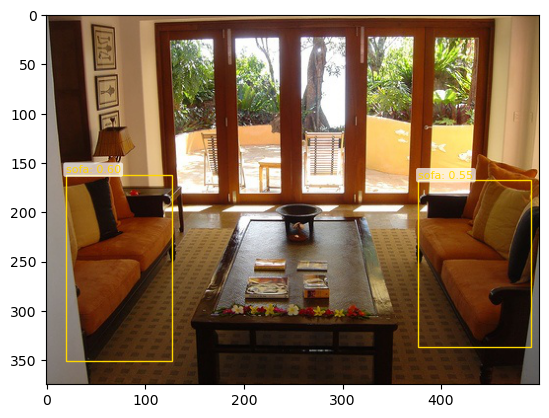

In [29]:
# boxes is either 'target_boxes' or 'pred_boxes'
plot_bbox_on_img("100examples.csv", 78, target_boxes)

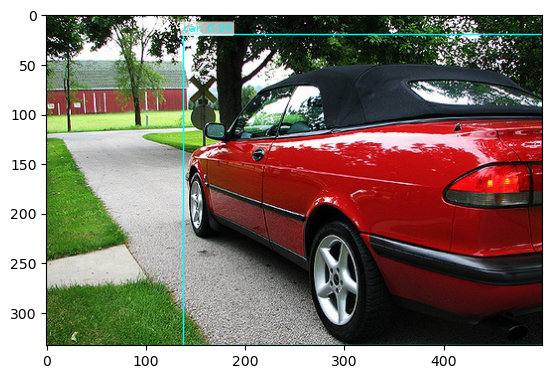

In [20]:
plot_image(cv2.imread("data/images/000007.jpg")[...,::-1], [box for box in pred_boxes if box[0] == 0], classEnum_to_color, pascal_voc_classes)

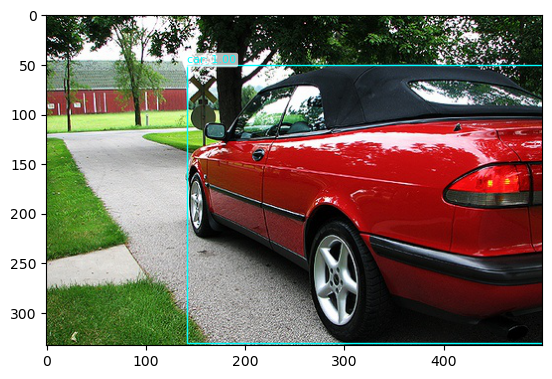

In [21]:
plot_image(cv2.imread("data/images/000007.jpg")[...,::-1], [box for box in target_boxes if box[0] == 0], classEnum_to_color, pascal_voc_classes)

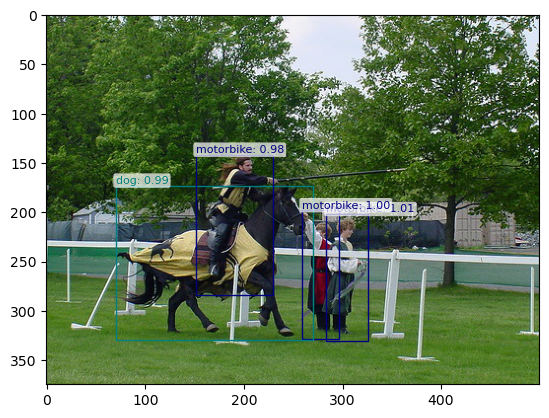

In [11]:
plot_image(cv2.imread("data/images/000009.jpg")[...,::-1], [box for box in pred_boxes if box[0] == 1], classEnum_to_color, pascal_voc_classes)

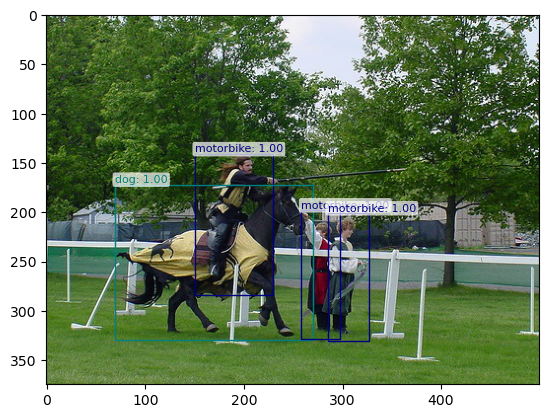

[[1, 14.0, 1.0, 0.3790000379085541, 0.5666667222976685, 0.15800002217292786, 0.3813333213329315], [1, 12.0, 1.0, 0.33900001645088196, 0.6693333387374878, 0.4020000398159027, 0.421333372592926], [1, 14.0, 1.0, 0.5550000071525574, 0.7026666402816772, 0.07800000160932541, 0.34933337569236755], [1, 14.0, 1.0, 0.6119999885559082, 0.7093333601951599, 0.08400000631809235, 0.34666669368743896]]


In [12]:
plot_image(cv2.imread("data/images/000009.jpg")[...,::-1], [box for box in target_boxes if box[0] == 1], classEnum_to_color, pascal_voc_classes)
print([box for box in target_boxes if box[0] == 1])

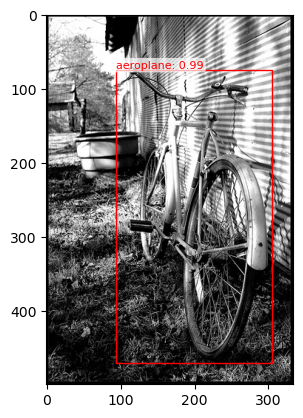

[[2, 1.0, 0.9892320036888123, 0.5954568982124329, 0.5455138087272644, 0.6310238838195801, 0.7928422093391418]]


In [13]:
plot_image(cv2.imread("data/images/000016.jpg")[...,::-1], [box for box in pred_boxes if box[0] == 2], classEnum_to_color, pascal_voc_classes)
print([box for box in pred_boxes if box[0] == 2])

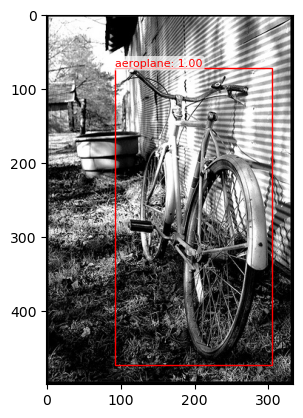

In [14]:
plot_image(cv2.imread("data/images/000016.jpg")[...,::-1], [box for box in target_boxes if box[0] == 2], classEnum_to_color, pascal_voc_classes)